<div dir=ltr align=center>In the name of God</div>
<br>
<font size=6><div dir=ltr align=center>
<font size=5>
Intelligent Analysis of
Biomedical Images
<br>
<font size=4>
sharif university of technology, CE department
</font>
<br>
<br>
<font size=6>
Homework 1.2
</font><br>
<font size=4>
Deep learning method
</font>

**First-Name: Lachin**

**Last-Name: Naghashyar**

**Student-Id: 98110179**

# Download Data

##### Execute the cell below to download the data required for your homework.

In [2]:
! pip install gdown

In [3]:

import gdown

url = 'https://drive.google.com/uc?id=1-2zT-_bKjN2o2QxwSviFwbCzcWE2PnkJ'

output = 'dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-2zT-_bKjN2o2QxwSviFwbCzcWE2PnkJ
To: /content/dataset.zip
100%|██████████| 368M/368M [00:02<00:00, 157MB/s]


'dataset.zip'

In [4]:
! unzip dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: mri_scans/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_30_mask.tif  
  inflating: mri_scans/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_23_mask.tif  
  inflating: mri_scans/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_27_mask.tif  
  inflating: mri_scans/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_21_mask.tif  
  inflating: mri_scans/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_5_mask.tif  
  inflating: mri_scans/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_15.tif  
  inflating: mri_scans/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_26.tif  
  inflating: mri_scans/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1.tif  
  inflating: mri_scans/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_5.tif  
  inflating: mri_scans/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_6.tif  
  inflating: mri_scans/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_18.tif  
  inflating: mri_scans/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_9.tif  
  inflating: mri_

# Import

In [5]:
import os
import numpy as np
import seaborn as sns
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io
import torch
import random
import pandas as pd
import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

# Config

In [6]:

RANDOM_SEED = 42 # Must be used wherever can be used

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Load and Process Data

##### This dataset contains brain MRI images and manual FLAIR abnormality segmentation masks, where each pixel value of masks indicates the presence or absence of cancer (0 and 1, respectively). The images correspond to 110 patients whose IDs are available in the patient_ids.csv file.


In [8]:
data = pd.read_csv('patient_ids.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      110 non-null    object
dtypes: object(1)
memory usage: 1008.0+ bytes


In [9]:
data.head()

,id
0,TCGA_CS_4941
1,TCGA_CS_4942
2,TCGA_CS_4943
3,TCGA_CS_4944
4,TCGA_CS_5393



### **Exercise 1 (5 points)**:

##### Please use the patient_ids.csv file and the images inside the mri_scans folder to generate a Pandas dataframe named mri_df. This dataframe should have columns labeled "patient_id", "image_path", and "mask_path".

In [10]:
data.columns

Index(['id'], dtype='object')

In [11]:
# Check if the subfolder for TCGA_CS_4941 exists
if os.path.exists(os.path.join('mri_scans', 'TCGA_CS_4941')):
    print("Subfolder for TCGA_CS_4941 exists.")
else:
    print("Subfolder for TCGA_CS_4941 does not exist.")

# List the contents of the subfolder for TCGA_HT_7881_19981015
print(f"\nContents of subfolder for TCGA_HT_7881_19981015:")
print(os.listdir(os.path.join('mri_scans', 'TCGA_HT_7881_19981015'))[:10])


Subfolder for TCGA_CS_4941 does not exist.

Contents of subfolder for TCGA_HT_7881_19981015:
['TCGA_HT_7881_19981015_4.tif', 'TCGA_HT_7881_19981015_74.tif', 'TCGA_HT_7881_19981015_53.tif', 'TCGA_HT_7881_19981015_5.tif', 'TCGA_HT_7881_19981015_3.tif', 'TCGA_HT_7881_19981015_68_mask.tif', 'TCGA_HT_7881_19981015_72.tif', 'TCGA_HT_7881_19981015_51_mask.tif', 'TCGA_HT_7881_19981015_13.tif', 'TCGA_HT_7881_19981015_26.tif']


In [12]:
image_paths = []
mask_paths = []
patient_ids = []

for patient_id in data['id']:
    patient_folder_path = glob.glob('mri_scans/*'+str(patient_id)+'*')[0]
    # print(patient_folder_path)
    if os.path.exists(patient_folder_path):
        all_tif_files = glob.glob(os.path.join(patient_folder_path, '*.tif'))

        patient_image_paths = [file for file in all_tif_files if '_mask' not in file]
        patient_mask_paths = [file for file in all_tif_files if '_mask' in file]

        image_paths.extend(patient_image_paths)
        mask_paths.extend(patient_mask_paths)
        patient_ids.extend([patient_id] * len(patient_image_paths))

mri_df = pd.DataFrame({
    'patient_id': patient_ids,
    'image_path': image_paths,
    'mask_path': mask_paths
})


In [13]:
# TODO
assert len(mri_df) == 3929
mri_df.head()

,patient_id,image_path,mask_path
0,TCGA_CS_4941,mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941_1...,mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941_1...
1,TCGA_CS_4941,mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941_1...,mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941_1...
2,TCGA_CS_4941,mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941_1...,mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941_1...
3,TCGA_CS_4941,mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941_1...,mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941_1...
4,TCGA_CS_4941,mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941_1...,mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941_1...



### **Exercise 2 (3 points)**:

##### Append a has_cancer column to the mri_df DataFrame, with values 0 indicating the absence of cancer and 1 indicating the presence of cancer. Then, convert the column to string type.

In [14]:
from skimage import io

def is_cancerous(mask_path):
    mask = io.imread(mask_path)

    total_pixel_value = mask.sum()

    if total_pixel_value > 0:
        return '1'
    else:
        return '0'


In [15]:
mri_df['has_cancer'] = mri_df['mask_path'].apply(lambda x: is_cancerous(x))
mri_df.head()

,patient_id,image_path,mask_path,has_cancer
0,TCGA_CS_4941,mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941_1...,mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941_1...,1
1,TCGA_CS_4941,mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941_1...,mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941_1...,1
2,TCGA_CS_4941,mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941_1...,mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941_1...,0
3,TCGA_CS_4941,mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941_1...,mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941_1...,1
4,TCGA_CS_4941,mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941_1...,mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941_1...,0


# Exploratory Data Analysis


### **Exercise 3 (1 points)**:

##### Calculate the number of images exhibiting the presence and absence of cancer.

In [16]:
cancer_counts = mri_df['has_cancer'].value_counts()

print("#images with cancer:", cancer_counts.get('1', 0))
print("#images without cancer:", cancer_counts.get('0', 0))


#images with cancer: 1373
#images without cancer: 2556



### **Exercise 4 (3 points)**:

##### Determine the proportion of pixels designated as cancerous in relation to the total pixel count. Perform this calculation first for all MRI images and subsequently for images displaying signs of cancer.

In [17]:
# Check unique pixel values in a few mask images
unique_values = []

for mask_path in mri_df['mask_path'][:10]:  # Checking first 10 mask images
    mask = io.imread(mask_path)
    unique_values.extend(np.unique(mask))

# Display unique pixel values
print("Unique pixel values in the first 10 mask images:", set(unique_values))


Unique pixel values in the first 10 mask images: {0, 255}


In [18]:
from skimage import io

cancerous_pixels_count = 0
total_pixels_count = 0

for mask_path in mri_df['mask_path']:
    mask = io.imread(mask_path)

    cancerous_pixels_count += (mask == 255).sum()
    total_pixels_count += mask.size

print(f'The proportion of cancerous pixels for all MRI images = {100 * cancerous_pixels_count / total_pixels_count:.2f}%')
print(f'The proportion of non-cancerous pixels for all MRI images = {100 * (total_pixels_count - cancerous_pixels_count) / total_pixels_count:.2f}%')


The proportion of cancerous pixels for all MRI images = 1.03%
The proportion of non-cancerous pixels for all MRI images = 98.97%


In [19]:

cancerous_images = mri_df[mri_df['has_cancer'] == '1']

cancerous_pixels_count_cancer_images = 0
total_pixels_count_cancer_images = 0

for mask_path in cancerous_images['mask_path']:
    mask = io.imread(mask_path)

    cancerous_pixels_count_cancer_images += (mask == 255).sum()
    total_pixels_count_cancer_images += mask.size

print(f'The proportion of cancerous pixels for images displaying signs of cancer = {100 * cancerous_pixels_count_cancer_images / total_pixels_count_cancer_images:.2f}%')
print(f'The proportion of non-cancerous pixels for images displaying signs of cancer = {100 * (total_pixels_count_cancer_images - cancerous_pixels_count_cancer_images) / total_pixels_count_cancer_images:.2f}%')


The proportion of cancerous pixels for images displaying signs of cancer = 2.95%
The proportion of non-cancerous pixels for images displaying signs of cancer = 97.05%


# Visualization

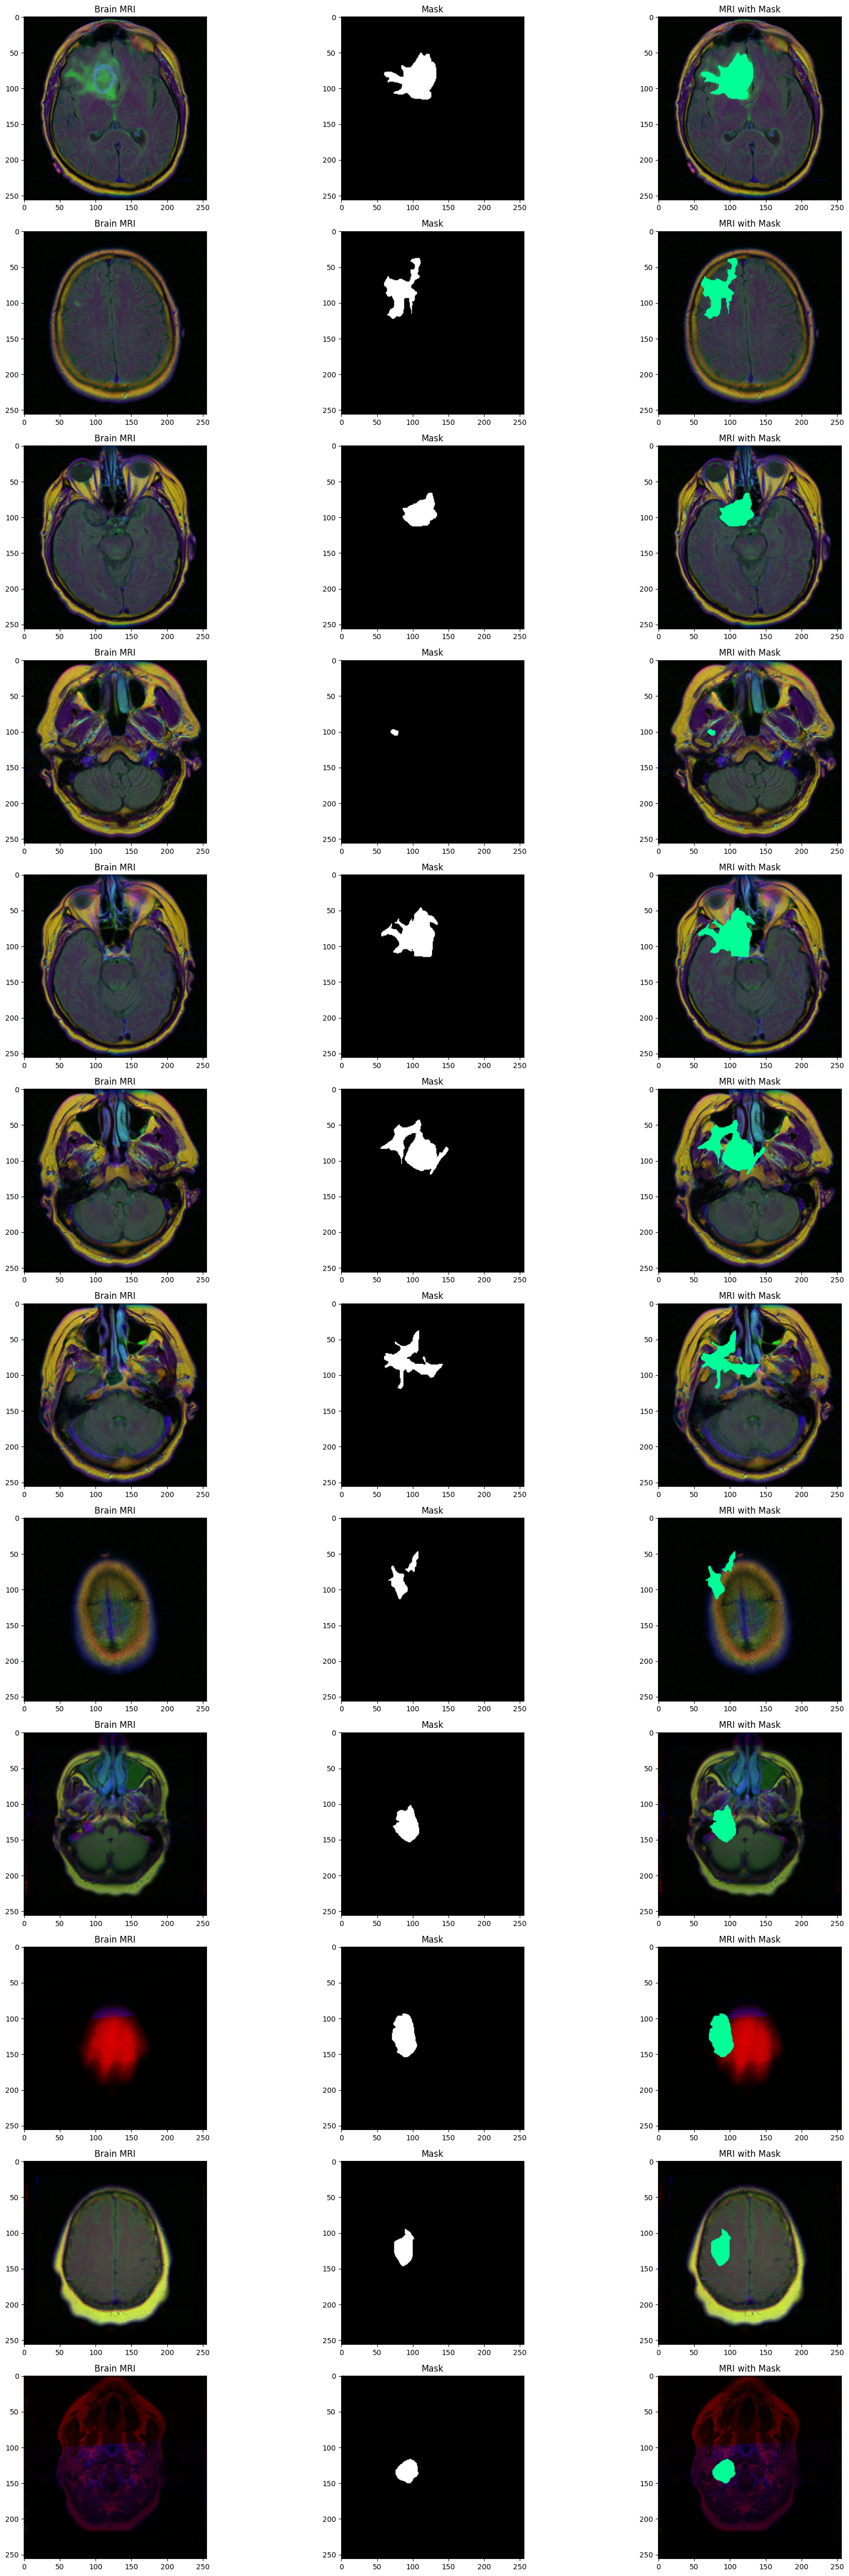

In [20]:
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for has_cancer in mri_df['has_cancer']:
    if (has_cancer=='1'):
        img = io.imread(mri_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)

        mask = io.imread(mri_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')

        img[mask==255] = (0,255,150)
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break

fig.tight_layout()

# Creata Dataset & DataLoader

#### Splitting To Train/Test/Val

##### Also, you are free to modify the below code.

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split

mri_df['has_cancer'] = mri_df['has_cancer'].apply(lambda x: str(x))

X_train, X_test, y_train, y_test = train_test_split(
    mri_df[['image_path']],
    mri_df[['has_cancer']],
    test_size=0.1,
    random_state=RANDOM_SEED,
    stratify = mri_df['has_cancer'],
)

train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

X_train, X_val, y_train, y_val = train_test_split(
    train_df[['image_path']],
    train_df[['has_cancer']],
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify = train_df['has_cancer']
)

train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
val_df = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)

train_df_zero = train_df[train_df['has_cancer'] == '0']
train_df_one = train_df[train_df['has_cancer'] == '1']

train_df = pd.concat([train_df_zero, train_df_one], axis=0).reset_index(drop=True)
print(f'train df count: {len(train_df)}')
print(f'test df count: {len(test_df)}')
print(f'validation df count: {len(val_df)}')

train df count: 2828
test df count: 393
validation df count: 708


In [22]:
print(train_df['has_cancer'].value_counts())
print(val_df['has_cancer'].value_counts())
print(test_df['has_cancer'].value_counts())

0    1839
1     989
Name: has_cancer, dtype: int64
0    461
1    247
Name: has_cancer, dtype: int64
0    256
1    137
Name: has_cancer, dtype: int64


### **Exercise 5 (5 points)**:

##### Complete the code for the functions of BrainMRIDataset class (mask pixel values must be either 0 or 1).

In [38]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
from PIL import Image


import functools

class BrainMRIDataset(Dataset):
    def __init__(self, dataframe, image_transform=None, cache_size=4000):
        self.dataframe = dataframe
        self.image_transform = image_transform

        # LRU cache for image loading
        self.load_image = functools.lru_cache(maxsize=cache_size)(self._load_image)

    def _load_image(self, image_path):
        return Image.open(image_path)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx, 0]
        has_cancer = int(self.dataframe.iloc[idx, 1])

        image = self.load_image(image_path)  # Use the cached version

        if self.image_transform:
            image = self.image_transform(image)

        return image, torch.tensor(has_cancer)

BATCH_SIZE = 128

train_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])



train_dataset = BrainMRIDataset(
    train_df,
    image_transform=train_transform,
)
val_dataest = BrainMRIDataset(
    val_df,
    image_transform=test_transform,
)
test_dataset = BrainMRIDataset(
    test_df,
    image_transform=test_transform,
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataest, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# **Classification**

##### You will be constructing a classification model designed to determine the presence of cancer in an image. To accomplish this task, utilize a pre-trained model (e.g., ResNet, Inception).

### **Exercise 6: Implement Your Classifier (15 points)**:

##### You are free to make every layer frozen or trainable.

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.resnet = models.resnet34(pretrained=True)

        for param in self.resnet.parameters():
            param.requires_grad = False

        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 1)

        for param in self.resnet.fc.parameters():
            param.requires_grad = True

        # self.features = nn.Sequential(*list(self.resnet.children())[:-1])

        # self.classifier = nn.Linear(512, 1)
        # for param in self.classifier.parameters():
        #     param.requires_grad = True

    # def forward(self, x):
    #     x = self.features(x)
    #     x = x.view(x.size(0), -1)
    #     x = self.classifier(x)
    #     return x

    def forward(self, x):
      return self.resnet(x)


# class Classifier(nn.Module):
#     def __init__(self):
#         super(Classifier, self).__init__()

#         self.resnet = models.resnet18(pretrained=True)

#         for param in self.resnet.parameters():
#             param.requires_grad = False

#         self.features = nn.Sequential(*list(self.resnet.children())[:-1])

#         self.classifier = nn.Sequential(
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(128, 1)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = Classifier()
model.to(device)

Classifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

### **Exercise 7 (5 points)**:

##### Define your optimizer, criterion, and learning rate scheduler.


##### **Note**: Do not forget to address the class imbalance problem.


In [40]:
import torch.optim as optim
from torch.optim import lr_scheduler

lr = 0.0001

num_cancer = (mri_df['has_cancer'] == '1').sum()
num_no_cancer = (mri_df['has_cancer'] == '0').sum()
total = len(mri_df)
weight_no_cancer = total / (2 * num_no_cancer)
weight_cancer = total / (2 * num_cancer)
class_weights = torch.tensor([weight_cancer]).to(device)


print(f"Weight for No Cancer class: {weight_no_cancer}")
print(f"Weight for Cancer class: {weight_cancer}")

criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

optimizer = optim.SGD(model.parameters(), lr=lr)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)


Weight for No Cancer class: 0.7685837245696401
Weight for Cancer class: 1.4308084486525856


### **Exercise 8 & 9 (35 points)**:

##### Complete the code for training and validation.

In [41]:
!pip install tqdm
from tqdm.notebook import tqdm

In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def train_one_epoch(model, loader, criterion, optimizer, device, dataset_size):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1).float()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    return running_loss / dataset_size


def validate_one_epoch(model, loader, criterion, device, dataset_size):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs).round()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds) * 100
    recall = recall_score(all_labels, all_preds) * 100
    f1 = f1_score(all_labels, all_preds) * 100

    return running_loss / dataset_size, accuracy, precision, recall, f1

from tqdm.notebook import tqdm

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"), criterion, optimizer, device, len(train_dataloader.dataset))
    val_loss, acc, precision, recall, f1 = validate_one_epoch(model, val_dataloader, criterion, device, len(val_dataloader.dataset))
    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Loss: {train_loss:.4f} - "
          f"Validation Loss: {val_loss:.4f} - "
          f"Validation: ACC {acc:.4f}% - "
          f"Validation Precision: {precision:.4f}% - "
          f"Validation: Recall {recall:.4f}% - "
          f"Validation F1: {f1:.2f}%")

Training Epoch 1:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [1/10] - Loss: 0.8068 - Validation Loss: 0.8045 - Validation: ACC 58.7571% - Validation Precision: 35.0993% - Validation: Recall 21.4575% - Validation F1: 26.63%


Training Epoch 2:   0%|          | 0/23 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

It takes TOO long to run each epoch and I wasn't successful to run it more than few epochs.

# **Exercise 10: Evaluation (30 points)**:

##### Evaluate your model with the metrics you defined earlier on your test data (f1 > 0.7 is required).

In [ ]:
model.eval()

test_loss, test_acc, test_precision, test_recall, test_f1 = validate_one_epoch(model, test_dataloader, criterion, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}%")
print(f"Test Precision: {test_precision:.4f}%")
print(f"Test Recall: {test_recall:.4f}%")
print(f"Test F1 Score: {test_f1:.4f}%")

if test_f1 > 70:
    print("Model evaluation is successful with F1 score greater than 0.7!")
else:
    print("Model needs improvement, F1 score is below 0.7.")



# **Exercise 11: Report (5 points)**:

##### Visualize the confusion matrix and find the weaknesses of your model (describe it in 2 lines).

In [ ]:
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

        outputs = model(inputs)
        preds = torch.sigmoid(outputs).round()

        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_test_labels, all_test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


#### Your description:


# **Exercise 12: Feature Space Visualization (20 points)**:


![feature-space-vis.png](attachment:feature-space-vis.png)

##### You have trained and evaluated your model. Now, for each image in the trainset, calculate it's "feature space" (After Applying Final Pooling).

##### Use **TSNE** to visualize the points in a 2D plane (Set color of each point based on it's class).


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        return x

feature_extractor = FeatureExtractor(model).to(device)
all_features = []
all_labels = []

with torch.no_grad():
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        features = feature_extractor(inputs)
        all_features.append(features.cpu().numpy())
        all_labels.extend(labels)

all_features = np.concatenate(all_features, axis=0)

tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(all_features.reshape(all_features.shape[0], -1))


plt.figure(figsize=(12, 10))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=all_labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('Feature Space Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()
